# Grocery Inventory Analysis

This notebook contains a complete analysis of grocery inventory and sales data, with all functions defined directly within the notebook (no imports from external Python files).

#### Project Scenario for Analysis:
"Optimizing Inventory & Sales Strategy of FreshMart Grocery Store"

FreshMart is a growing grocery retail chain with multiple outlets across the city. The company is facing multiple challenges like:
1.	Overstocking of slow-moving items
2.	Stockouts of fast-moving products
3.	Expiry of unsold items
4.	Poor visibility of best-performing products
5.	Seasonal sales variation not being captured properly

To overcome these issues, FreshMart management wants a Data-Driven Sales & Inventory Analysis to understand:
1.	Product performance
2.	Customer buying trends
3.	Inventory optimization opportunities
4.	Seasonal sales behavior
5.	Supplier management



#### Business Objective:
"Analyze the Inventory and Sales Data of FreshMart Grocery to help the management in making data-driven decisions on stocking, sales strategy, and supplier management." And "To perform an End-to-End Sales & Inventory Data Analysis of FreshMart Grocery Store with the goal of identifying business insights and actionable recommendations to optimize sales, manage inventory effectively, and improve profitability."

#### Problem Statement:
FreshMart, a rapidly expanding grocery retail chain, is currently facing several operational and sales-related challenges that are directly impacting its profitability and customer satisfaction.
Due to the lack of a proper data-driven strategy, FreshMart is experiencing:
1. Overstocking of slow-moving products, leading to unnecessary inventory holding costs and wastage.
2. Frequent stockouts of fast-moving items, resulting in lost sales opportunities and customer dissatisfaction.
3. Increased instances of product expiry, especially for perishable items, causing direct financial losses.
4. Lack of clear visibility into best-selling and worst-selling products across different categories and locations.
5. Inability to identify seasonal trends in customer purchases, leading to inefficient stock planning.
 
 Poor supplier performance tracking and management.
1.	Which products are best & worst-performing?
2.	Which product categories generate the highest sales & profit?
3.	Is there a seasonal pattern in customer buying?
4.	Which items are overstocked or understocked?
5.	Are there any losses due to expiry or unsold inventory?
6.	What should be the reorder strategy for key products?



#### Goals of the Analysis:
1.	Identify best-selling and worst-selling products.
2.	Understand seasonal sales patterns.
3.	Analyze stockout and overstock situations.
4.	Evaluate supplier performance.
5.	Provide strategies for inventory optimization.
6.	Recommend actions to improve sales growth.


## Setup and Imports

In [113]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import seaborn as sns
import geopandas as gpd
import os
from datetime import datetime, timedelta

# Set up directories
OUTPUT_DIR = 'outputs'
PLOTS_DIR = os.path.join(OUTPUT_DIR, 'plots')
REPORTS_DIR = os.path.join(OUTPUT_DIR, 'reports')

# Ensure directories exist
os.makedirs(PLOTS_DIR, exist_ok=True)
os.makedirs(REPORTS_DIR, exist_ok=True)

## 2. Function Definitions

In [114]:
# Data loading function
def load_data(file_path):
    print(f"Loading data from {file_path}")
    return pd.read_csv(file_path)

In [115]:
# Data validation function
def validate_data(df):
    print("Validating data...")
    
    # Check required columns
    required_columns = [
        'Product_ID', 'Catagory', 'Stock_Quantity', 'Reorder_Level',
        'Unit_Price', 'Sales_Volume', 'Expiration_Date'
    ]
    
    # Map dataset columns to required columns for analysis
    column_mapping = {
        'Catagory': 'Product_Category',
        'Sales_Volume': 'Quantity_Sold',
        'Stock_Quantity': 'Stock_On_Hand',
        'Expiration_Date': 'Expiry_Date'
    }
    
    # Rename columns for analysis
    df = df.rename(columns=column_mapping)
    
    # Convert price columns from string to float (remove $ and convert)
    if 'Unit_Price' in df.columns:
        df['Unit_Price'] = df['Unit_Price'].str.replace('$', '').str.strip().astype(float)
    
    # Convert dates to datetime
    if 'Expiry_Date' in df.columns:
        df['Expiry_Date'] = pd.to_datetime(df['Expiry_Date'], errors='coerce')
    
    # Calculate profit based on sales and price if not available
    if 'Profit' not in df.columns:
        # Assuming 20% profit margin for simplicity
        df['Profit'] = df['Quantity_Sold'] * df['Unit_Price'] * 0.2
    
    # Add a Discount column if not present (set to 0)
    if 'Discount_%' not in df.columns:
        df['Discount_%'] = 0
    
    return df

In [116]:
# Data preprocessing function
def preprocess_data(df):
    print("Preprocessing data...")
    
    # Handle missing values
    for col in df.columns:
        if df[col].dtype in [np.int64, np.float64]:
            # Fill numeric columns with median
            df[col] = df[col].fillna(df[col].median())
        else:
            # Fill categorical columns with "Unknown" or most frequent
            df[col] = df[col].fillna(df[col].mode()[0] if not df[col].mode().empty else "Unknown")
    
    # Outlier treatment for numeric columns
    for col in ['Quantity_Sold', 'Stock_On_Hand']:
        if col in df.columns:
            q1 = df[col].quantile(0.25)
            q3 = df[col].quantile(0.75)
            iqr = q3 - q1
            upper_bound = q3 + 1.5 * iqr
            # Cap values above 95th percentile
            df[col] = np.where(df[col] > df[col].quantile(0.95), df[col].quantile(0.95), df[col])
    
    # Create derived columns
    df['Inventory_Turnover_Ratio'] = df['Quantity_Sold'] / df['Stock_On_Hand']
    df['Overstock_Flag'] = df['Stock_On_Hand'] > 2 * df['Reorder_Level']
    
    # If Reorder_Level is missing, assume it as Avg_Monthly_Sales * 1.5
    # (using Quantity_Sold as a proxy for monthly sales)
    if 'Reorder_Level' in df.columns and df['Reorder_Level'].isna().any():
        df['Reorder_Level'] = df['Reorder_Level'].fillna(df['Quantity_Sold'] * 1.5)
    
    # Calculate total revenue
    df['Total_Revenue'] = df['Quantity_Sold'] * df['Unit_Price']
    
    return df

In [143]:
import plotly.express as px

def analyze_overstocked_products(df):
    print("[PRIORITY] Analyzing overstocked products...")

    # Filter overstocked products
    overstocked = df[df['Overstock_Flag'] == True].sort_values(by='Stock_On_Hand', ascending=False)

    # Create report
    overstocked_report = overstocked[['Product_ID', 'Product_Name', 'Product_Category',
                                     'Stock_On_Hand', 'Reorder_Level', 'Quantity_Sold',
                                     'Inventory_Turnover_Ratio']]
    
    # Save report
    overstocked_report.to_csv(os.path.join(REPORTS_DIR, 'overstocked_products.csv'), index=False)

    # Interactive Plot: Top 15 Overstocked Products
    top_15 = overstocked.head(15)
    fig = px.bar(
        top_15,
        x='Product_Name',
        y='Stock_On_Hand',
        color='Product_Category',
        hover_data=['Product_ID', 'Reorder_Level', 'Quantity_Sold', 'Inventory_Turnover_Ratio'],
        title='Top 15 Overstocked Products',
        labels={'Product_Name': 'Product', 'Stock_On_Hand': 'Stock Quantity'},
        template='plotly_white'  # You can try 'plotly_dark' too
    )

    # Make layout pretty
    fig.update_layout(
        xaxis_tickangle=-45,
        margin=dict(l=40, r=40, t=80, b=120),
        font=dict(size=12),
        title_font_size=20
    )

    fig.show()
    
    return overstocked


In [118]:
# Analysis: Top Products

def analyze_top_products(df):
    print("[PRIORITY] Analyzing top products by quantity sold and revenue...")

    # Top 10 products by quantity sold and revenue
    top_by_quantity = df.sort_values(by='Quantity_Sold', ascending=False).head(10)
    top_by_revenue = df.sort_values(by='Total_Revenue', ascending=False).head(10)

    # Save reports
    top_by_quantity[['Product_ID', 'Product_Name', 'Product_Category', 'Quantity_Sold',
                     'Unit_Price', 'Total_Revenue']].to_csv(
                     os.path.join(REPORTS_DIR, 'top_products_by_quantity.csv'), index=False)

    top_by_revenue[['Product_ID', 'Product_Name', 'Product_Category', 'Quantity_Sold',
                    'Unit_Price', 'Total_Revenue']].to_csv(
                    os.path.join(REPORTS_DIR, 'top_products_by_revenue.csv'), index=False)

    # Set dark background style
    sns.set_style("darkgrid", {"axes.facecolor": "#1c1c1c"})
    plt.rcParams.update({
        'axes.edgecolor': 'white',
        'xtick.color': 'white',
        'ytick.color': 'white',
        'text.color': 'white',
        'axes.labelcolor': 'white',
        'figure.facecolor': '#1c1c1c',
        'axes.facecolor': '#1c1c1c'
    })

    # Plot: Top by Quantity Sold
    plt.figure(figsize=(12, 8))
    sns.barplot(data=top_by_quantity, y='Product_Name', x='Quantity_Sold', palette='crest')
    plt.title('🌟 Top 10 Products by Quantity Sold', fontsize=16, fontweight='bold')
    plt.xlabel('Quantity Sold', fontsize=12)
    plt.ylabel('Product Name', fontsize=12)
    for i, value in enumerate(top_by_quantity['Quantity_Sold']):
        plt.text(value, i, f'{value:,}', va='center', ha='left', fontsize=10, color='yellow')
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, 'top_products_by_quantity.png'), dpi=300, facecolor='#1c1c1c')
    plt.show()

    # Plot: Top by Revenue
    plt.figure(figsize=(12, 8))
    sns.barplot(data=top_by_revenue, y='Product_Name', x='Total_Revenue', palette='mako')
    plt.title('💰 Top 10 Products by Revenue', fontsize=16, fontweight='bold')
    plt.xlabel('Total Revenue (₹)', fontsize=12)
    plt.ylabel('Product Name', fontsize=12)
    for i, value in enumerate(top_by_revenue['Total_Revenue']):
        plt.text(value, i, f'₹{value:,.2f}', va='center', ha='left', fontsize=10, color='yellow')
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, 'top_products_by_revenue.png'), dpi=300, facecolor='#1c1c1c')
    plt.show()

    return top_by_quantity, top_by_revenue


In [119]:


def analyze_top_products(df):
    print("[PRIORITY] Analyzing top products by quantity sold and revenue...")

    # Top 10 products by quantity sold and revenue
    top_by_quantity = df.sort_values(by='Quantity_Sold', ascending=False).head(10)
    top_by_revenue = df.sort_values(by='Total_Revenue', ascending=False).head(10)

    # Save reports
    top_by_quantity[['Product_ID', 'Product_Name', 'Product_Category', 'Quantity_Sold',
                     'Unit_Price', 'Total_Revenue']].to_csv(
                     os.path.join(REPORTS_DIR, 'top_products_by_quantity.csv'), index=False)

    top_by_revenue[['Product_ID', 'Product_Name', 'Product_Category', 'Quantity_Sold',
                    'Unit_Price', 'Total_Revenue']].to_csv(
                    os.path.join(REPORTS_DIR, 'top_products_by_revenue.csv'), index=False)

    # Plot: Top by Quantity Sold
    plt.figure(figsize=(12, 8))
    sns.barplot(data=top_by_quantity, x='Quantity_Sold', y='Product_Name', palette='crest')
    plt.title('🌟 Top 10 Products by Quantity Sold', fontsize=16, fontweight='bold')
    plt.xlabel('Quantity Sold', fontsize=12)
    plt.ylabel('Product Name', fontsize=12)
    for i, value in enumerate(top_by_quantity['Quantity_Sold']):
        plt.text(value, i, f'{value:,}', va='center', ha='left', fontsize=10)
    plt.grid(axis='x', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, 'top_products_by_quantity.png'), dpi=300)
    plt.show()

    # Plot: Top by Revenue
    plt.figure(figsize=(12, 8))
    sns.barplot(data=top_by_revenue, x='Total_Revenue', y='Product_Name', palette='mako')
    plt.title('💰 Top 10 Products by Total Revenue', fontsize=16, fontweight='bold')
    plt.xlabel('Total Revenue (₹)', fontsize=12)
    plt.ylabel('Product Name', fontsize=12)
    for i, value in enumerate(top_by_revenue['Total_Revenue']):
        plt.text(value, i, f'₹{value:,.2f}', va='center', ha='left', fontsize=10)
    plt.grid(axis='x', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, 'top_products_by_revenue.png'), dpi=300)
    plt.show()

    return top_by_quantity, top_by_revenue


In [120]:
# Analysis: Category Revenue
def analyze_category_revenue(df):
    print("[PRIORITY] Analyzing category-wise revenue...")
    
    # Aggregate by category
    category_revenue = df.groupby('Product_Category').agg({
        'Total_Revenue': 'sum',
        'Quantity_Sold': 'sum',
        'Product_ID': 'count'  # count of products
    }).reset_index().sort_values(by='Total_Revenue', ascending=False)
    
    category_revenue = category_revenue.rename(columns={'Product_ID': 'Product_Count'})
    
    # Save report
    category_revenue.to_csv(os.path.join(REPORTS_DIR, 'category_revenue.csv'), index=False)
    
    # Create visualization
    plt.figure(figsize=(12, 8))
    sns.barplot(data=category_revenue, x='Product_Category', y='Total_Revenue')
    plt.xticks(rotation=45)
    plt.title('Total Revenue by Product Category')
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, 'category_revenue.png'))
    
    return category_revenue

In [121]:
# Analysis: Expiry Risk
def analyze_expiry_risk(df):
    print("[PRIORITY] Analyzing expiry risk...")
    
    if 'Expiry_Date' not in df.columns:
        print("Expiry_Date column not available. Skipping expiry risk analysis.")
        return None
    
    # Calculate days until expiry
    today = datetime.now()
    df['Days_To_Expiry'] = (df['Expiry_Date'] - today).dt.days
    
    # Create risk categories
    df['Expiry_Risk'] = 'Green'
    df.loc[df['Days_To_Expiry'] <= 60, 'Expiry_Risk'] = 'Yellow'
    df.loc[df['Days_To_Expiry'] <= 30, 'Expiry_Risk'] = 'Red'
    
    # Filter products with expiry risk
    at_risk = df[df['Expiry_Risk'] != 'Green'].sort_values(by='Days_To_Expiry')
    
    # Focus on products with stock
    at_risk_with_stock = at_risk[at_risk['Stock_On_Hand'] > 0]
    
    # Save report
    at_risk_with_stock[['Product_ID', 'Product_Name', 'Product_Category', 
                       'Stock_On_Hand', 'Days_To_Expiry', 'Expiry_Risk', 'Unit_Price']].to_csv(
                       os.path.join(REPORTS_DIR, 'expiry_risk.csv'), index=False)
    
    # Create visualization - count of products by risk category
    risk_counts = at_risk_with_stock['Expiry_Risk'].value_counts().reset_index()
    risk_counts.columns = ['Risk_Category', 'Count']
    
    plt.figure(figsize=(10, 6))
    colors = {'Red': 'red', 'Yellow': 'yellow', 'Green': 'green'}
    ax = sns.barplot(data=risk_counts, x='Risk_Category', y='Count', palette=colors)
    plt.title('Product Count by Expiry Risk Category')
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, 'expiry_risk.png'))
    
    return at_risk_with_stock

In [122]:


def analyze_2025_expiry_risk(df):
    print("[PRIORITY] Analyzing expiry risk for products expiring in 2025...")
    
    if 'Expiry_Date' not in df.columns:
        print("Expiry_Date column not available. Skipping 2025 expiry risk analysis.")
        return None
    
    # Filter products with expiry in 2025
    df_2025 = df[df['Expiry_Date'].dt.year == 2025].copy()
    
    if df_2025.empty:
        print("No products with expiry in 2025 found.")
        return None

    # Calculate days until expiry
    today = datetime.now()
    df_2025['Days_To_Expiry'] = (df_2025['Expiry_Date'] - today).dt.days
    
    # Create risk categories
    df_2025['Expiry_Risk'] = 'Green'
    df_2025.loc[df_2025['Days_To_Expiry'] <= 60, 'Expiry_Risk'] = 'Yellow'
    df_2025.loc[df_2025['Days_To_Expiry'] <= 30, 'Expiry_Risk'] = 'Red'
    
    # Filter products with expiry risk
    at_risk_2025 = df_2025[df_2025['Expiry_Risk'] != 'Green'].sort_values(by='Days_To_Expiry')
    
    # Focus on products with stock
    at_risk_2025_with_stock = at_risk_2025[at_risk_2025['Stock_On_Hand'] > 0]
    
    # Save CSV report
    at_risk_2025_with_stock[['Product_ID', 'Product_Name', 'Product_Category', 
                             'Stock_On_Hand', 'Days_To_Expiry', 'Expiry_Risk', 'Unit_Price']].to_csv(
                             os.path.join(REPORTS_DIR, 'expiry_risk_2025.csv'), index=False)
    
    # Create visualization - count of 2025 at-risk products
    risk_counts = at_risk_2025_with_stock['Expiry_Risk'].value_counts().reset_index()
    risk_counts.columns = ['Risk_Category', 'Count']
    
    plt.figure(figsize=(10, 6))
    colors = {'Red': 'red', 'Yellow': 'yellow', 'Green': 'green'}
    sns.barplot(data=risk_counts, x='Risk_Category', y='Count', palette=colors)
    plt.title('2025 Expiry Risk: Product Count by Risk Category')
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, 'expiry_risk_2025.png'))
    
    return at_risk_2025_with_stock


In [123]:
# Analysis: Discount Impact
def analyze_discount_impact(df):
    print("[OPTIONAL] Analyzing discount impact...")
    
    if 'Discount_%' not in df.columns or df['Discount_%'].sum() == 0:
        print("Discount data not available or all values are 0. Skipping discount impact analysis.")
        return None
    
    # Create scatter plot of Discount vs Quantity Sold
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='Discount_%', y='Quantity_Sold')
    plt.title('Impact of Discount on Quantity Sold')
    plt.xlabel('Discount %')
    plt.ylabel('Quantity Sold')
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, 'discount_impact.png'))
    
    # Correlation analysis
    correlation = df['Discount_%'].corr(df['Quantity_Sold'])
    
    with open(os.path.join(REPORTS_DIR, 'discount_correlation.txt'), 'w') as f:
        f.write(f"Correlation between Discount and Quantity Sold: {correlation:.4f}")
    
    return correlation

In [124]:
# Generate Executive Summary
def generate_executive_summary(df, overstocked, top_revenue, category_revenue, expiry_risk):
    print("Generating executive summary...")
    
    insights = []
    
    # Insight 1: Overstocked products
    if overstocked is not None and not overstocked.empty:
        overstock_value = (overstocked['Stock_On_Hand'] * overstocked['Unit_Price']).sum()
        insights.append(f"[PRIORITY] There are {len(overstocked)} overstocked products with a total value of ${overstock_value:.2f}. Consider running promotions or reducing reorder quantities.")
    
    # Insight 2: Top revenue generators
    if top_revenue is not None and not top_revenue.empty:
        top_category = category_revenue.iloc[0]['Product_Category']
        top_revenue_pct = (category_revenue.iloc[0]['Total_Revenue'] / category_revenue['Total_Revenue'].sum()) * 100
        insights.append(f"[PRIORITY] The {top_category} category generates ${category_revenue.iloc[0]['Total_Revenue']:.2f} in revenue ({top_revenue_pct:.1f}% of total). Consider expanding this product line.")
    
    # Insight 3: Expiry risk
    if expiry_risk is not None and not expiry_risk.empty:
        red_risk = expiry_risk[expiry_risk['Expiry_Risk'] == 'Red']
        if not red_risk.empty:
            red_risk_value = (red_risk['Stock_On_Hand'] * red_risk['Unit_Price']).sum()
            insights.append(f"[PRIORITY] {len(red_risk)} products worth ${red_risk_value:.2f} will expire within 30 days. Immediate action required with promotions or discounts.")
    
    # Insight 4: Inventory turnover
    low_turnover = df[df['Inventory_Turnover_Ratio'] < 1].sort_values(by='Inventory_Turnover_Ratio')
    if not low_turnover.empty:
        low_turnover_value = (low_turnover['Stock_On_Hand'] * low_turnover['Unit_Price']).sum()
        insights.append(f"[PRIORITY] {len(low_turnover)} products have low turnover rates (<1), tying up ${low_turnover_value:.2f} in inventory. Review pricing strategy and promotions.")
    
    # Insight 5: Stock-outs risk
    potential_stockouts = df[df['Stock_On_Hand'] < df['Reorder_Level']]
    if not potential_stockouts.empty:
        high_revenue_at_risk = potential_stockouts.sort_values(by='Total_Revenue', ascending=False).head(5)
        at_risk_revenue = high_revenue_at_risk['Total_Revenue'].sum()
        insights.append(f"[PRIORITY] {len(potential_stockouts)} products are below reorder levels, putting ${at_risk_revenue:.2f} in revenue at risk. Expedite restocking of top sellers.")
    
    # Write to file
    with open(os.path.join(REPORTS_DIR, 'executive_summary.md'), 'w') as f:
        f.write("# Executive Summary: Grocery Inventory and Sales Analysis\n\n")
        f.write("## Key Insights and Action Items\n\n")
        for i, insight in enumerate(insights[:5], 1):
            f.write(f"{i}. {insight}\n\n")
    
    return insights

## Data Loading and Processing

In [125]:
# Load data
data_path = 'data/Grocery_Inventory_and_Sales_Dataset.csv'
df = load_data(data_path)

# Display first few rows of the raw data
print("Raw data preview:")
df.head()

Loading data from data/Grocery_Inventory_and_Sales_Dataset.csv
Raw data preview:


,Product_ID,Product_Name,Catagory,Supplier_ID,Supplier_Name,Stock_Quantity,Reorder_Level,Reorder_Quantity,Unit_Price,Date_Received,Last_Order_Date,Expiration_Date,Warehouse_Location,Sales_Volume,Inventory_Turnover_Rate,Status
0,29-205-1132,Sushi Rice,Grains & Pulses,38-037-1699,Jaxnation,22,72,70,$4.50,8/16/2024,6/29/2024,9/19/2024,48 Del Sol Trail,32,19,Discontinued
1,40-681-9981,Arabica Coffee,Beverages,54-470-2479,Feedmix,45,77,2,$20.00,11/1/2024,5/29/2024,5/8/2024,36 3rd Place,85,1,Discontinued
2,06-955-3428,Black Rice,Grains & Pulses,54-031-2945,Vinder,30,38,83,$6.00,8/3/2024,6/10/2024,9/22/2024,3296 Walton Court,31,34,Backordered
3,71-594-6552,Long Grain Rice,Grains & Pulses,63-492-7603,Brightbean,12,59,62,$1.50,12/8/2024,2/19/2025,4/17/2024,3 Westerfield Crossing,95,99,Active
4,57-437-1828,Plum,Fruits & Vegetables,54-226-4308,Topicstorm,37,30,74,$4.00,7/3/2024,10/11/2024,10/5/2024,15068 Scoville Court,62,25,Backordered


In [126]:
# Data info and missing values
print("Data info:")
df.info()

print("\nMissing values:")
df.isnull().sum()

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 0 to 989
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Product_ID               990 non-null    object
 1   Product_Name             990 non-null    object
 2   Catagory                 989 non-null    object
 3   Supplier_ID              990 non-null    object
 4   Supplier_Name            990 non-null    object
 5   Stock_Quantity           990 non-null    int64 
 6   Reorder_Level            990 non-null    int64 
 7   Reorder_Quantity         990 non-null    int64 
 8   Unit_Price               990 non-null    object
 9   Date_Received            990 non-null    object
 10  Last_Order_Date          990 non-null    object
 11  Expiration_Date          990 non-null    object
 12  Warehouse_Location       990 non-null    object
 13  Sales_Volume             990 non-null    int64 
 14  Inventory_Turnover_Rate  990 no

Product_ID                 0
Product_Name               0
Catagory                   1
Supplier_ID                0
Supplier_Name              0
Stock_Quantity             0
Reorder_Level              0
Reorder_Quantity           0
Unit_Price                 0
Date_Received              0
Last_Order_Date            0
Expiration_Date            0
Warehouse_Location         0
Sales_Volume               0
Inventory_Turnover_Rate    0
Status                     0
dtype: int64

In [127]:
# Check for duplicate data
df.duplicated().sum() # None

np.int64(0)

In [128]:
# Validate and preprocess data
df_validated = validate_data(df)
df_processed = preprocess_data(df_validated)

# Display first few rows of the processed data
print("Processed data preview:")
df_processed.head()

Validating data...
Preprocessing data...
Processed data preview:


,Product_ID,Product_Name,Product_Category,Supplier_ID,Supplier_Name,Stock_On_Hand,Reorder_Level,Reorder_Quantity,Unit_Price,Date_Received,...,Expiry_Date,Warehouse_Location,Quantity_Sold,Inventory_Turnover_Rate,Status,Profit,Discount_%,Inventory_Turnover_Ratio,Overstock_Flag,Total_Revenue
0,29-205-1132,Sushi Rice,Grains & Pulses,38-037-1699,Jaxnation,22.0,72,70,4.5,8/16/2024,...,2024-09-19,48 Del Sol Trail,32.0,19,Discontinued,28.8,0,1.454545,False,144.0
1,40-681-9981,Arabica Coffee,Beverages,54-470-2479,Feedmix,45.0,77,2,20.0,11/1/2024,...,2024-05-08,36 3rd Place,85.0,1,Discontinued,340.0,0,1.888889,False,1700.0
2,06-955-3428,Black Rice,Grains & Pulses,54-031-2945,Vinder,30.0,38,83,6.0,8/3/2024,...,2024-09-22,3296 Walton Court,31.0,34,Backordered,37.2,0,1.033333,False,186.0
3,71-594-6552,Long Grain Rice,Grains & Pulses,63-492-7603,Brightbean,12.0,59,62,1.5,12/8/2024,...,2024-04-17,3 Westerfield Crossing,95.0,99,Active,28.5,0,7.916667,False,142.5
4,57-437-1828,Plum,Fruits & Vegetables,54-226-4308,Topicstorm,37.0,30,74,4.0,7/3/2024,...,2024-10-05,15068 Scoville Court,62.0,25,Backordered,49.6,0,1.675676,False,248.0


## 4. Category-Wise Product Count

In [129]:
import plotly.express as px

# Group by Product Category and count the number of products within each category
category_wise_product_count = df_validated.groupby('Product_Category')['Product_Name'].count().reset_index()

# Rename the columns for clarity
category_wise_product_count.columns = ['Product_Category', 'Product_Count']

# Create an interactive bar chart with Plotly
fig = px.bar(category_wise_product_count,
             x='Product_Category', 
             y='Product_Count',
             color='Product_Category',  # Color by category for better distinction
             title='Category-Wise Product Count',
             labels={'Product_Category': 'Product Category', 'Product_Count': 'Number of Products'},
             template='plotly_dark')  # Optional: Use a dark theme

# Show the chart
fig.update_layout(xaxis_tickangle=-45)  # Rotate x-axis labels for better readability
fig.show()




## 5. Analysis: Overstocked Products

In [130]:
# Analyze overstocked products
overstocked = analyze_overstocked_products(df_processed)

# Display top overstocked products
print(f"Found {len(overstocked)} overstocked products")
overstocked[['Product_ID', 'Product_Name', 'Product_Category', 'Stock_On_Hand', 'Reorder_Level', 'Inventory_Turnover_Ratio']].head(10)

[PRIORITY] Analyzing overstocked products...


Found 258 overstocked products


,Product_ID,Product_Name,Product_Category,Stock_On_Hand,Reorder_Level,Inventory_Turnover_Ratio
909,67-382-4435,Green Beans,Fruits & Vegetables,96.55,37,0.476437
159,49-861-7823,Coconut,Fruits & Vegetables,96.55,8,0.424650
140,02-655-3240,Rice Flour,Grains & Pulses,96.55,44,0.372864
899,77-827-0820,Sesame Oil,Oils & Fats,96.55,20,0.528224
902,44-128-2185,Jasmine Rice,Grains & Pulses,96.55,20,0.528224
747,54-758-4622,Chocolate Biscuit,Bakery,96.55,3,0.673226
718,08-637-9335,Lettuce,Fruits & Vegetables,96.55,7,0.269291
225,56-191-6497,Bread Flour,Grains & Pulses,96.55,41,0.362506
245,59-075-2457,Egg (Goose),Dairy,96.55,26,0.341792
855,46-911-1159,Onion,Fruits & Vegetables,96.55,40,0.476437


In [144]:
# Calculate total value of overstocked inventory
overstock_value = (overstocked['Stock_On_Hand'] * overstocked['Unit_Price']).sum()
print(f"Total value of overstocked inventory: ${overstock_value:.2f}")

Total value of overstocked inventory: $117920.54


## 5. Analysis: Top Products

[PRIORITY] Analyzing top products by quantity sold and revenue...


C:\Users\INDRANIL SAHA\AppData\Local\Temp\ipykernel_6272\1073421721.py:19: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


C:\Users\INDRANIL SAHA\AppData\Local\Temp\ipykernel_6272\1073421721.py:26: UserWarning:

Glyph 127775 (\N{GLOWING STAR}) missing from font(s) Arial.

C:\Users\INDRANIL SAHA\AppData\Local\Temp\ipykernel_6272\1073421721.py:27: UserWarning:

Glyph 127775 (\N{GLOWING STAR}) missing from font(s) Arial.

d:\PYTHON_PROJECT\grocery_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 127775 (\N{GLOWING STAR}) missing from font(s) Arial.



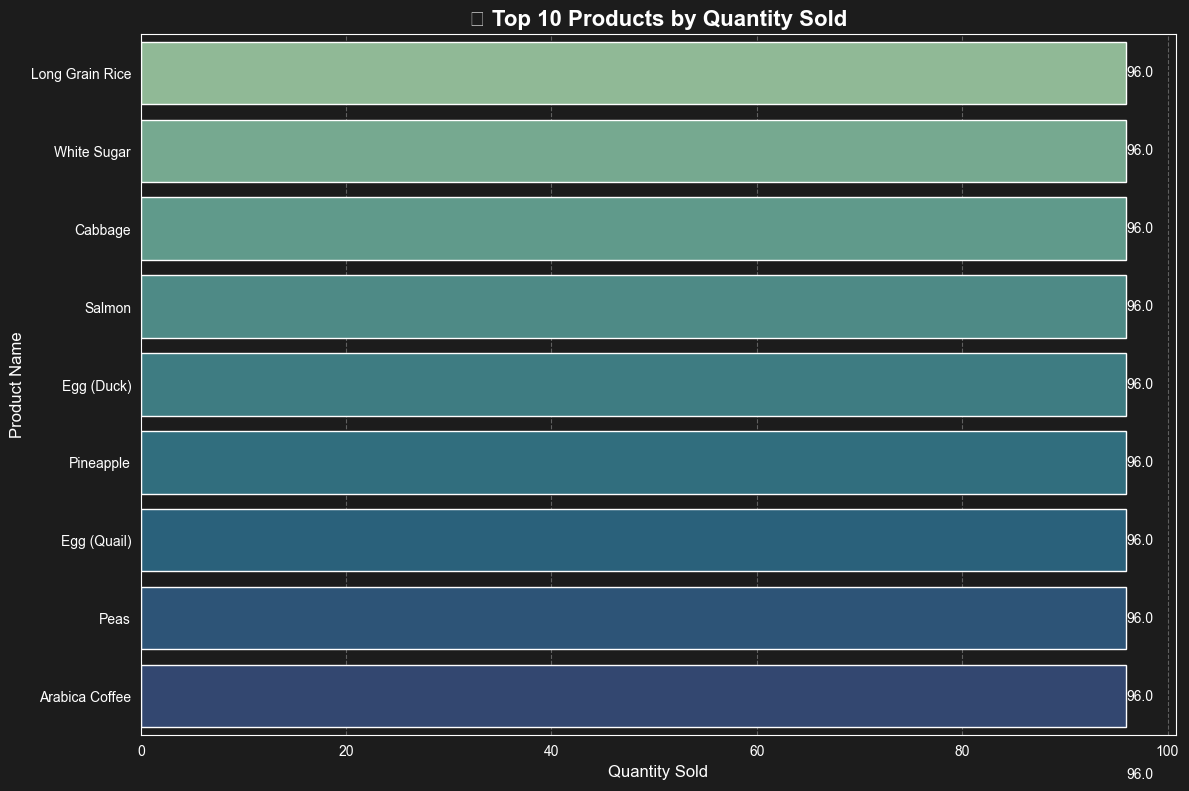

C:\Users\INDRANIL SAHA\AppData\Local\Temp\ipykernel_6272\1073421721.py:32: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


C:\Users\INDRANIL SAHA\AppData\Local\Temp\ipykernel_6272\1073421721.py:39: UserWarning:

Glyph 128176 (\N{MONEY BAG}) missing from font(s) Arial.

C:\Users\INDRANIL SAHA\AppData\Local\Temp\ipykernel_6272\1073421721.py:40: UserWarning:

Glyph 128176 (\N{MONEY BAG}) missing from font(s) Arial.

d:\PYTHON_PROJECT\grocery_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 128176 (\N{MONEY BAG}) missing from font(s) Arial.



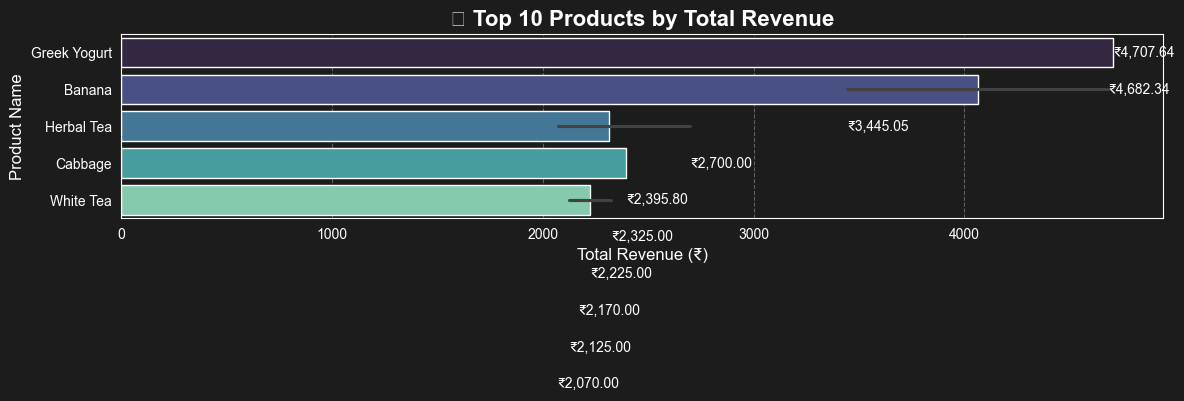

Top products by quantity sold:


,Product_Name,Product_Category,Quantity_Sold,Unit_Price,Total_Revenue
10,Long Grain Rice,Grains & Pulses,96.0,1.6,153.6
11,White Sugar,Grains & Pulses,96.0,2.0,192.0
987,Cabbage,Fruits & Vegetables,96.0,0.9,86.4
463,Salmon,Seafood,96.0,15.0,1440.0
445,Egg (Duck),Dairy,96.0,1.0,96.0
52,Pineapple,Fruits & Vegetables,96.0,3.4,326.4
26,Egg (Quail),Dairy,96.0,0.8,76.8
512,Peas,Fruits & Vegetables,96.0,3.0,288.0
538,Arabica Coffee,Beverages,96.0,20.0,1920.0
567,Egg (Quail),Dairy,96.0,0.8,76.8


In [132]:
# Analyze top products
top_quantity, top_revenue = analyze_top_products(df_processed)

# Display top products by quantity
print("Top products by quantity sold:")
top_quantity[['Product_Name', 'Product_Category', 'Quantity_Sold', 'Unit_Price', 'Total_Revenue']].head(10)

In [133]:
# Display top products by revenue
print("Top products by revenue:")
top_revenue[['Product_Name', 'Product_Category', 'Quantity_Sold', 'Unit_Price', 'Total_Revenue']].head(10)

Top products by revenue:


,Product_Name,Product_Category,Quantity_Sold,Unit_Price,Total_Revenue
208,Greek Yogurt,Fruits & Vegetables,92.0,51.17,4707.64
325,Banana,Fruits & Vegetables,87.0,53.82,4682.34
113,Banana,Fruits & Vegetables,35.0,98.43,3445.05
630,Herbal Tea,Beverages,90.0,30.00,2700.00
685,Cabbage,Fruits & Vegetables,36.0,66.55,2395.80
66,White Tea,Beverages,93.0,25.00,2325.00
485,White Tea,Beverages,89.0,25.00,2225.00
161,Herbal Tea,Beverages,70.0,31.00,2170.00
349,White Tea,Beverages,85.0,25.00,2125.00
235,Herbal Tea,Beverages,69.0,30.00,2070.00


## 7. Distribution of Product Prices

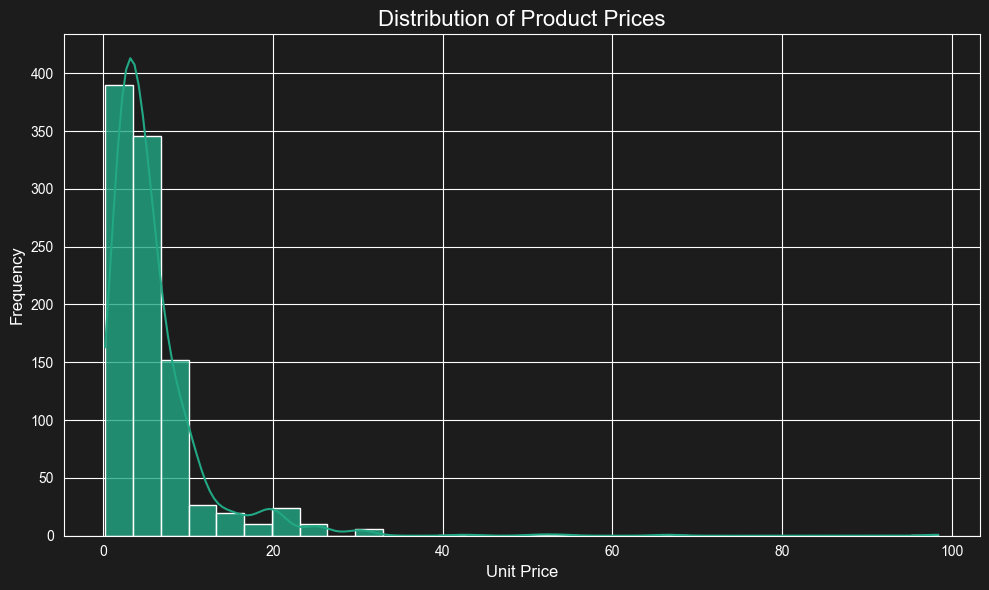

In [134]:
# Plot a colorful histogram for the distribution of product prices
plt.figure(figsize=(10, 6))
sns.histplot(df_processed['Unit_Price'], bins=30, kde=True, color=sns.color_palette("viridis", as_cmap=True)(0.6), alpha=0.8)

# Add labels and title
plt.title('Distribution of Product Prices', fontsize=16)
plt.xlabel('Unit Price', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

## 8. Monthly Sales Trend

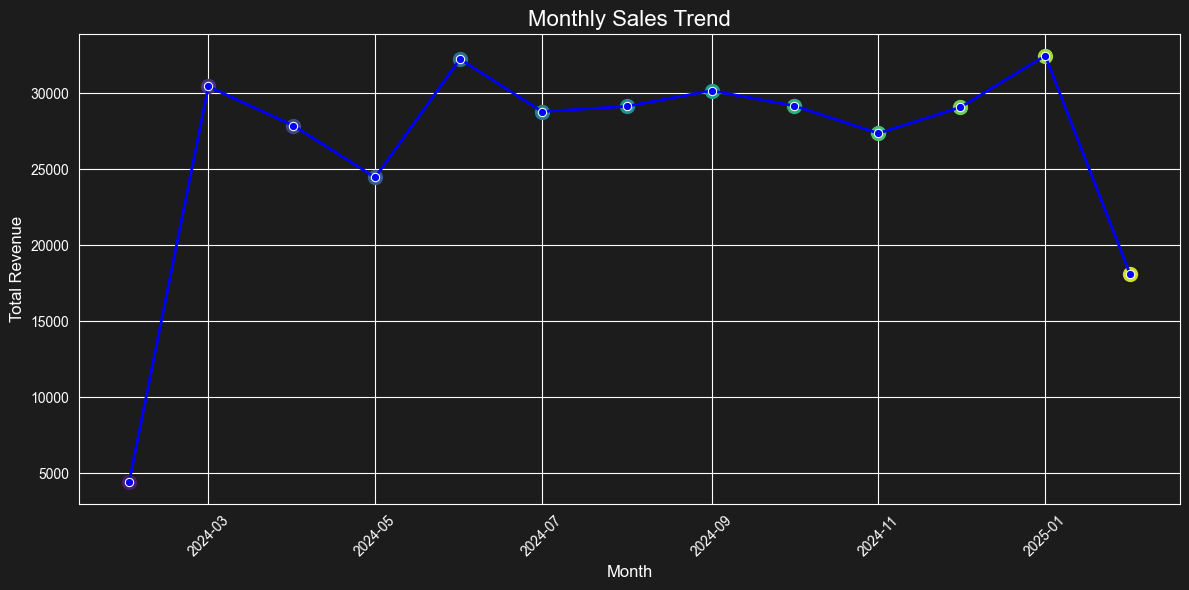

In [135]:
# Convert 'Date_Received' to datetime if not already
df_processed['Date_Received'] = pd.to_datetime(df_processed['Date_Received'], errors='coerce')

# Extract year and month from 'Date_Received'
df_processed['YearMonth'] = df_processed['Date_Received'].dt.to_period('M')

# Group by 'YearMonth' and calculate total revenue
monthly_sales = df_processed.groupby('YearMonth')['Total_Revenue'].sum().reset_index()

# Convert 'YearMonth' back to datetime for plotting
monthly_sales['YearMonth'] = monthly_sales['YearMonth'].dt.to_timestamp()

# Plot the monthly sales trend with a colorful line
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_sales, x='YearMonth', y='Total_Revenue', marker='o', color='blue', linewidth=2)

# Add scatter points with a gradient color palette
colors = sns.color_palette("viridis", len(monthly_sales))
for i, row in monthly_sales.iterrows():
    plt.scatter(row['YearMonth'], row['Total_Revenue'], color=colors[i], s=100)

plt.title('Monthly Sales Trend', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Revenue', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 9. Inventory vs Sales 

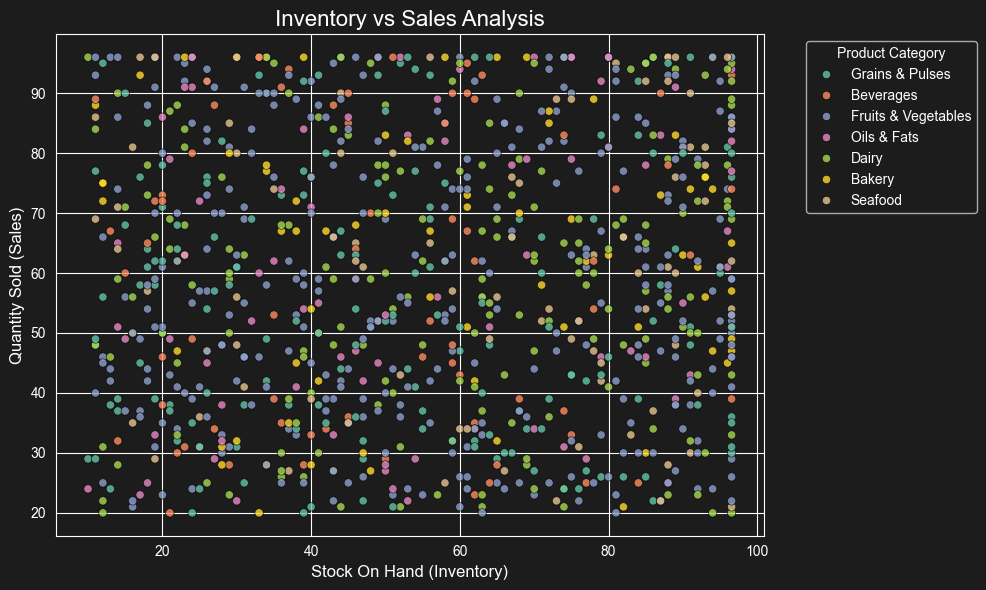

In [136]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_processed,
    x='Stock_On_Hand',
    y='Quantity_Sold',
    hue='Product_Category',
    palette='Set2',  # bright and good for categories
    alpha=0.8,
    edgecolor='black',
    linewidth=0.5
)

plt.title('Inventory vs Sales Analysis', fontsize=16)
plt.xlabel('Stock On Hand (Inventory)', fontsize=12)
plt.ylabel('Quantity Sold (Sales)', fontsize=12)
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## 8. Cost vs Profit Comparison

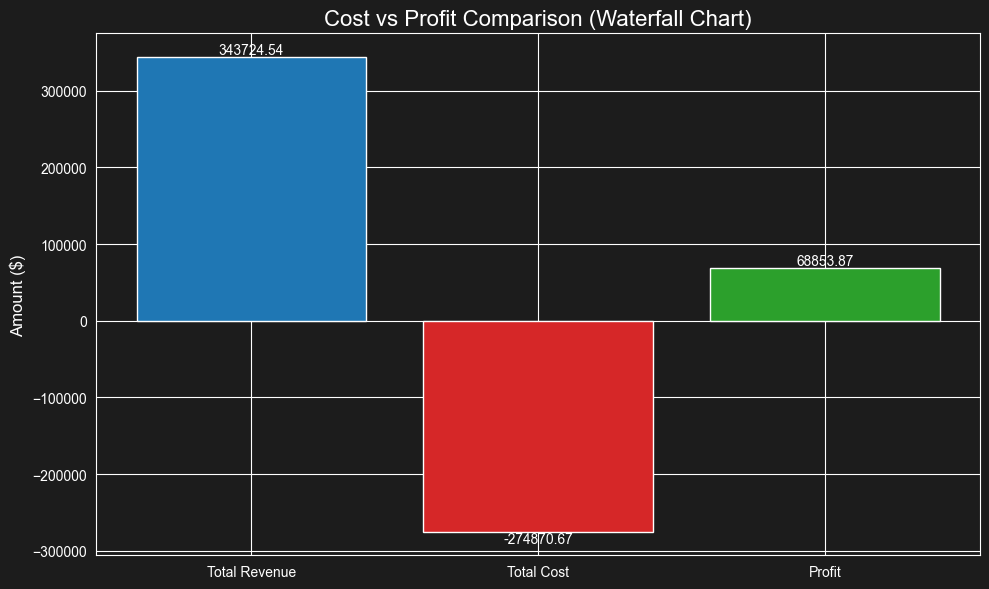

In [137]:
# Calculate total cost and profit
total_revenue = df_processed['Total_Revenue'].sum()
total_profit = df_processed['Profit'].sum()
total_cost = total_revenue - total_profit

# Prepare data for the waterfall chart
data = {
    'Category': ['Total Revenue', 'Total Cost', 'Profit'],
    'Values': [total_revenue, -total_cost, total_profit]
}

# Create a DataFrame for the waterfall chart
waterfall_data = pd.DataFrame(data)

# Define an improved color palette (blue for revenue, red for cost, green for profit)
colors = ['#1f77b4', '#d62728', '#2ca02c']  # Custom: Dark blue, Red, Green

# Plot the waterfall chart
plt.figure(figsize=(10, 6))
bars = plt.bar(waterfall_data['Category'], waterfall_data['Values'], color=colors)

# Add value annotations
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}', ha='center', va='bottom' if yval > 0 else 'top')

# Add labels and title
plt.title('Cost vs Profit Comparison (Waterfall Chart)', fontsize=16)
plt.ylabel('Amount ($)', fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

## 10. Warehouse Wise Stock Distribution

In [ ]:
import plotly.express as px

# Aggregate stock by warehouse
warehouse_stock = df_processed.groupby('Warehouse_Location')['Stock_On_Hand'].sum().reset_index()

# Sort the data by stock in descending order and select the top 10
top_warehouses = warehouse_stock.sort_values(by='Stock_On_Hand', ascending=False).head(10)

# Create a Plotly treemap for the top 10 warehouses
fig = px.treemap(top_warehouses, 
                 path=['Warehouse_Location'], 
                 values='Stock_On_Hand', 
                 color='Stock_On_Hand',
                 color_continuous_scale='Viridis',
                 title='Top 10 Warehouses by Stock Distribution')

# Show the interactive treemap
fig.update_layout(margin={"t": 40, "l": 40, "r": 40, "b": 40})
fig.show()


## 11. Count Plot	To count how many products each supplier provides.

C:\Users\INDRANIL SAHA\AppData\Local\Temp\ipykernel_6272\1139353822.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




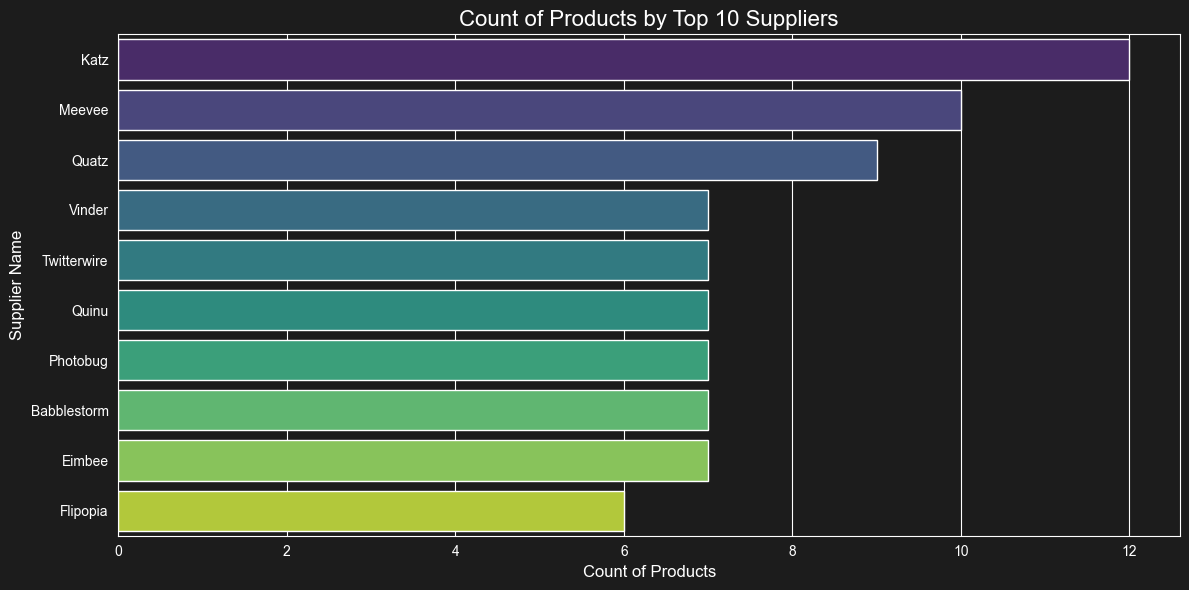

In [92]:

# Count plot for the number of products each supplier provides
plt.figure(figsize=(12, 6))
top_suppliers = df_validated['Supplier_Name'].value_counts().head(10).index  # Top 10 suppliers
sns.countplot(data=df_validated[df_validated['Supplier_Name'].isin(top_suppliers)], y='Supplier_Name', palette='viridis', order=top_suppliers, hue=None, legend=False)
plt.title('Count of Products by Top 10 Suppliers', fontsize=16)
plt.xlabel('Count of Products', fontsize=12)
plt.ylabel('Supplier Name', fontsize=12)
plt.tight_layout()
plt.show()

## 12. Supplier-wise Sales Analysis

In [96]:
import plotly.express as px
import pandas as pd

# Aggregate sales data by supplier and product category
supplier_sales = df_processed.groupby(['Supplier_Name', 'Product_Category']).agg({
    'Total_Revenue': 'sum',
    'Quantity_Sold': 'sum'
}).reset_index()

# Calculate total revenue per supplier
supplier_total_revenue = supplier_sales.groupby('Supplier_Name')['Total_Revenue'].sum().reset_index()

# Get the top 10 suppliers by total revenue
top_suppliers = supplier_total_revenue.nlargest(10, 'Total_Revenue')['Supplier_Name']

# Filter the original data for only the top 10 suppliers
top_supplier_sales = supplier_sales[supplier_sales['Supplier_Name'].isin(top_suppliers)]

# Pivot the data for a stacked bar chart
supplier_sales_pivot = top_supplier_sales.pivot(index='Supplier_Name', columns='Product_Category', values='Total_Revenue').fillna(0)

# Sort suppliers by total revenue for better visualization
supplier_sales_pivot['Total'] = supplier_sales_pivot.sum(axis=1)
supplier_sales_pivot = supplier_sales_pivot.sort_values(by='Total', ascending=False).drop(columns='Total')

# Reset index for plotly
supplier_sales_pivot_reset = supplier_sales_pivot.reset_index()

# Create the interactive stacked bar chart using Plotly
fig = px.bar(supplier_sales_pivot_reset,
             x=supplier_sales_pivot_reset.columns[1:],  # All categories
             y='Supplier_Name',
             title="Top 10 Suppliers - Supplier-wise Sales Analysis",
             labels={'value': 'Total Revenue', 'Supplier_Name': 'Supplier'},
             color_discrete_sequence=px.colors.sequential.Viridis,
             height=600)

# Show the plot
fig.update_layout(barmode='stack',
                  xaxis_title="Total Revenue",
                  yaxis_title="Supplier Name",
                  legend_title="Product Category",
                  xaxis={'showgrid': False},
                  yaxis={'showgrid': False})
fig.show()


## 13. Outlier Detection

In [99]:
import plotly.express as px
import pandas as pd

# List of numerical columns
numerical_columns = ['Stock_On_Hand', 'Quantity_Sold', 'Unit_Price', 'Profit', 'Total_Revenue']

# Create an empty list to store box plot figures
figures = []

# Loop through the numerical columns and create box plots
for col in numerical_columns:
    fig = px.box(df_processed, y=col, title=f'Box Plot of {col}', 
                 color_discrete_sequence=["#1f77b4"])  # Using a consistent color for all plots
    fig.update_layout(
        title=f'Box Plot of {col}', 
        xaxis_title='', 
        yaxis_title=col, 
        title_font_size=16,
        title_x=0.5,
        xaxis=dict(showgrid=False), 
        yaxis=dict(showgrid=True),
        plot_bgcolor='black',  # Dark background
        paper_bgcolor='black',  # Dark background for the paper
        font=dict(color="white"),  # White font for better contrast
        boxmode='group'
    )
    figures.append(fig)

# Display all the box plots in a grid layout
# You can use plotly.subplots to arrange multiple figures
from plotly.subplots import make_subplots

# Create a subplot with 2 rows and 3 columns
fig = make_subplots(rows=2, cols=3, shared_xaxes=False, shared_yaxes=True,
                    subplot_titles=numerical_columns)

# Adding the individual box plots to the subplots
for i, col in enumerate(numerical_columns):
    row = (i // 3) + 1
    col_position = (i % 3) + 1
    fig.add_trace(figures[i].data[0], row=row, col=col_position)

# Update layout for the whole subplot
fig.update_layout(
    title_text="Box Plots for Numerical Columns",
    title_x=0.5,
    showlegend=False,
    plot_bgcolor='black',  # Dark background for the overall plot
    paper_bgcolor='black',  # Dark background for the paper
    font=dict(color="white")  # White font color for better contrast
)

# Show the final interactive plot
fig.show()


## 14. Analysis: Category Revenue

[PRIORITY] Analyzing category-wise revenue...


,Product_Category,Total_Revenue,Quantity_Sold,Product_Count
3,Fruits & Vegetables,91814.89,19374.0,332
1,Beverages,71429.55,4528.0,75
6,Seafood,61412.10,5563.0,90
2,Dairy,48244.15,10752.0,180
4,Grains & Pulses,33757.15,8871.0,162
5,Oils & Fats,18756.90,4587.0,77
0,Bakery,18309.80,4552.0,74


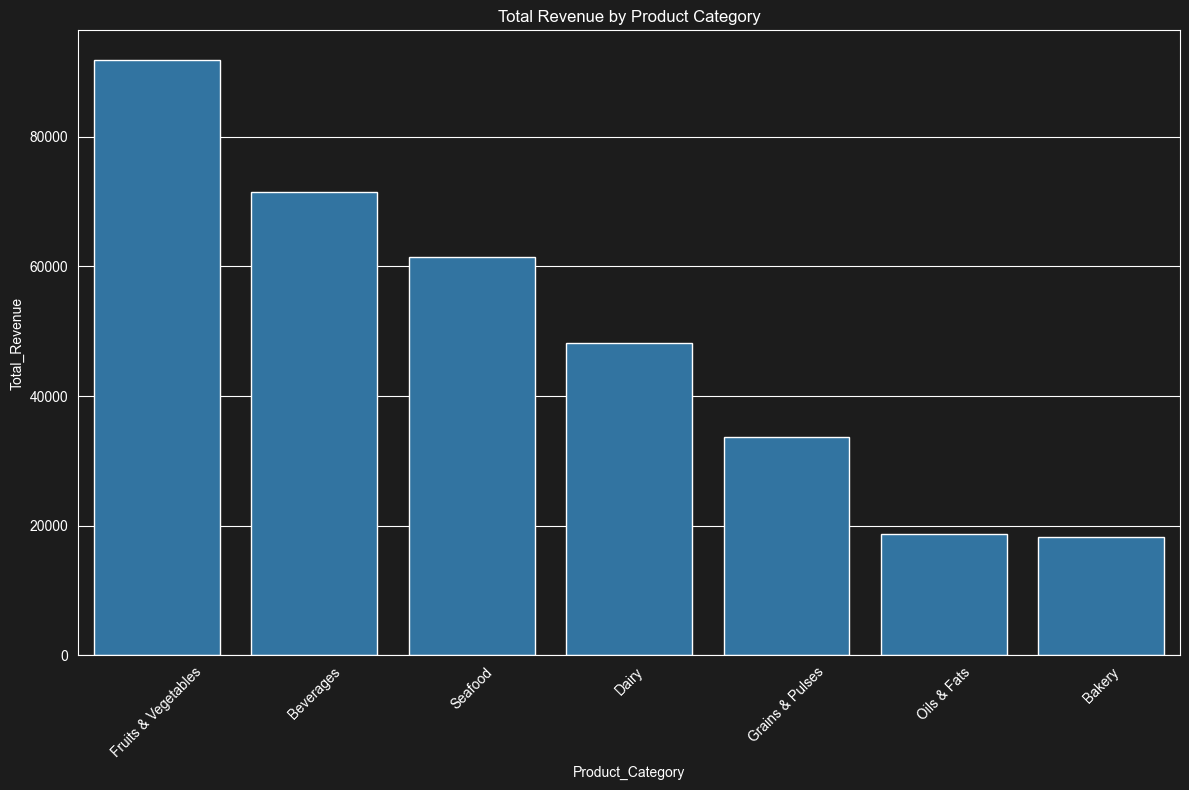

In [100]:
# Analyze category revenue
category_revenue = analyze_category_revenue(df_processed)

# Display category revenue
category_revenue

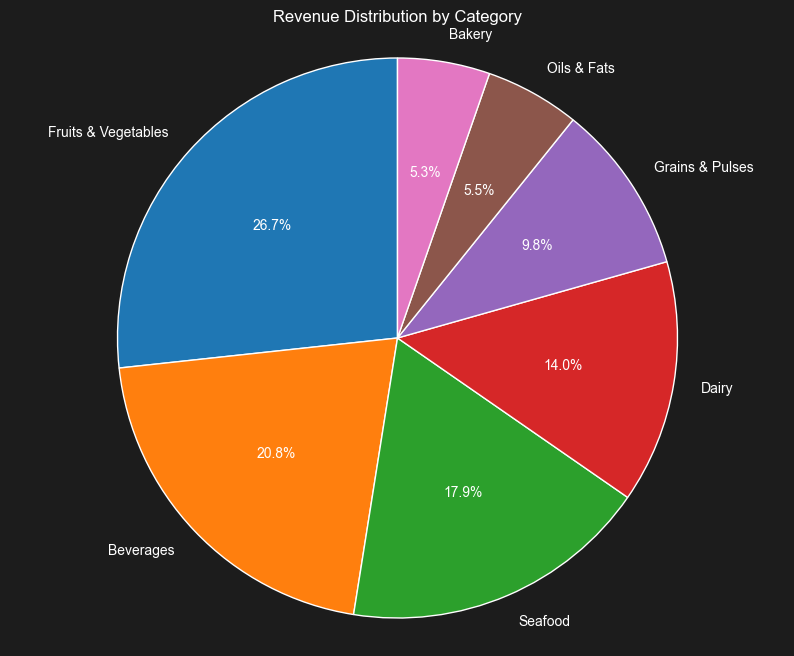

In [101]:
# Pie chart of revenue by category
plt.figure(figsize=(10, 8))
plt.pie(category_revenue['Total_Revenue'], labels=category_revenue['Product_Category'], 
        autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Revenue Distribution by Category')
plt.show()

## 15. Profit Contribution 

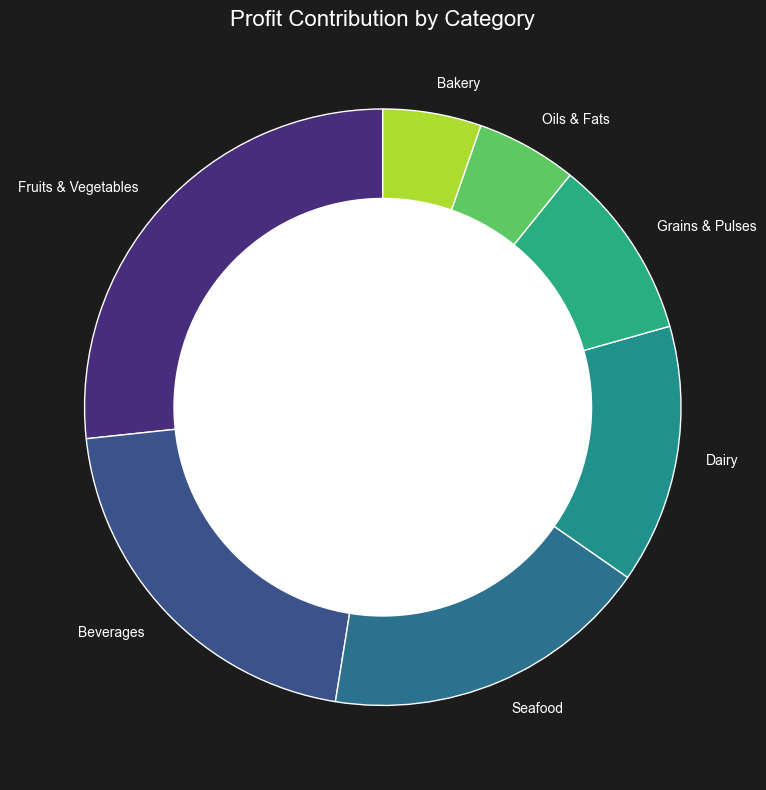

In [102]:
# Calculate profit contribution by category
profit_contribution = df_processed.groupby('Product_Category')['Profit'].sum().reset_index()

# Sort by profit in descending order
profit_contribution = profit_contribution.sort_values(by='Profit', ascending=False)

# Create a donut chart
plt.figure(figsize=(10, 8))
colors = sns.color_palette('viridis', len(profit_contribution))
plt.pie(profit_contribution['Profit'], labels=profit_contribution['Product_Category'], 
    autopct='%1.1f%%', startangle=90, colors=colors, wedgeprops={'width': 0.4})

# Add a center circle for the donut effect
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
plt.gca().add_artist(centre_circle)

# Add title
plt.title('Profit Contribution by Category', fontsize=16)

# Show the plot
plt.tight_layout()
plt.show()

## 16. Analysis: Expiry Risk

[PRIORITY] Analyzing expiry risk...
Found 990 products at risk of expiry


C:\Users\INDRANIL SAHA\AppData\Local\Temp\ipykernel_6272\442546703.py:35: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




          Product_Name     Product_Category  Stock_On_Hand  Days_To_Expiry  \
101        Bread Flour      Grains & Pulses           84.0            -415   
562     Robusta Coffee            Beverages           59.0            -415   
660             Salmon              Seafood           88.0            -415   
407     Cheddar Cheese                Dairy           21.0            -415   
193  Chocolate Biscuit               Bakery           11.0            -415   
194        Pomegranate  Fruits & Vegetables           14.0            -413   
940    Evaporated Milk                Dairy           64.0            -413   
716    Evaporated Milk                Dairy           70.0            -411   
953         Peanut Oil          Oils & Fats           21.0            -411   
767          Wild Rice      Grains & Pulses           41.0            -411   

    Expiry_Risk  Unit_Price  
101         Red        1.50  
562         Red       10.30  
660         Red       15.00  
407         Red      

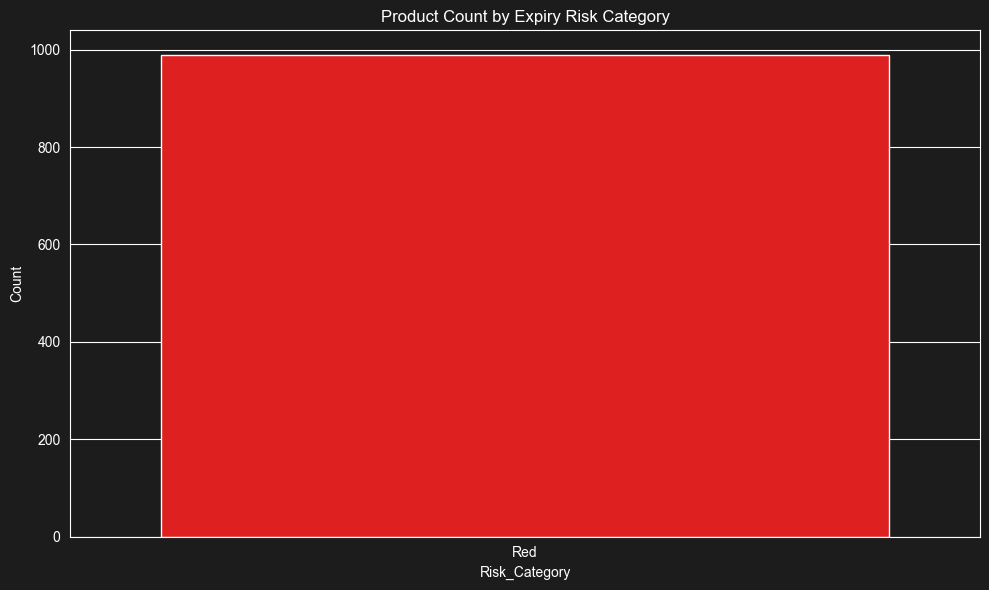

In [105]:
import plotly.express as px

# Assuming analyze_expiry_risk() is already defined and used
expiry_risk = analyze_expiry_risk(df_processed)

if expiry_risk is not None:
    # Display the number of products at risk of expiry
    print(f"Found {len(expiry_risk)} products at risk of expiry")
    
    # Create an interactive bar chart for the top 10 products at risk of expiry
    fig = px.bar(expiry_risk.head(10),
                 x='Product_Name',
                 y='Stock_On_Hand',
                 color='Expiry_Risk',
                 hover_data=['Product_Category', 'Days_To_Expiry', 'Unit_Price'],
                 title='Top 10 Products at Risk of Expiry',
                 labels={'Product_Name': 'Product', 'Stock_On_Hand': 'Stock Available'},
                 color_continuous_scale='reds')  # Use red color scale for urgency
    
    fig.update_layout(
        plot_bgcolor='black',
        paper_bgcolor='black',
        font=dict(color="white"),
        title_x=0.5
    )
    
    # Show the interactive plot
    fig.show()
    
    # Displaying the first 10 products at risk of expiry in a tabular format
    print(expiry_risk[['Product_Name', 'Product_Category', 'Stock_On_Hand', 'Days_To_Expiry', 'Expiry_Risk', 'Unit_Price']].head(10))
else:
    print("No expiry data available")


In [141]:
# Calculate the value of inventory at risk of expiry
if expiry_risk is not None:
    red_risk = expiry_risk[expiry_risk['Expiry_Risk'] == 'Red']
    yellow_risk = expiry_risk[expiry_risk['Expiry_Risk'] == 'Yellow']
    
    red_value = (red_risk['Stock_On_Hand'] * red_risk['Unit_Price']).sum()
    yellow_value = (yellow_risk['Stock_On_Hand'] * yellow_risk['Unit_Price']).sum()
    
    print(f"Value of inventory at high risk (Red): ${red_value:.2f}")
    print(f"Value of inventory at medium risk (Yellow): ${yellow_value:.2f}")

Value of inventory at high risk (Red): $332069.70
Value of inventory at medium risk (Yellow): $0.00


## 17. Analysis : Expiry risk in 2025

[PRIORITY] Analyzing expiry risk for products expiring in 2025...
Found 143 products at risk of expiry in 2025


C:\Users\INDRANIL SAHA\AppData\Local\Temp\ipykernel_6272\621210764.py:41: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




          Product_Name     Product_Category  Stock_On_Hand  Days_To_Expiry  \
633             Grapes  Fruits & Vegetables           59.0            -104   
599         Peanut Oil          Oils & Fats           21.0            -104   
349          White Tea            Beverages           58.0            -103   
728              Apple  Fruits & Vegetables           71.0            -103   
861  Whole Wheat Flour      Grains & Pulses           60.0            -103   
504  Mozzarella Cheese                Dairy           58.0            -102   
541       Egg (Turkey)                Dairy           39.0            -102   
127        Cauliflower      Grains & Pulses           40.0            -102   
950  Digestive Biscuit               Bakery           72.0            -102   
871         Canola Oil          Oils & Fats           53.0            -101   

    Expiry_Risk  Unit_Price  
633         Red        5.50  
599         Red        4.00  
349         Red       25.00  
728         Red      

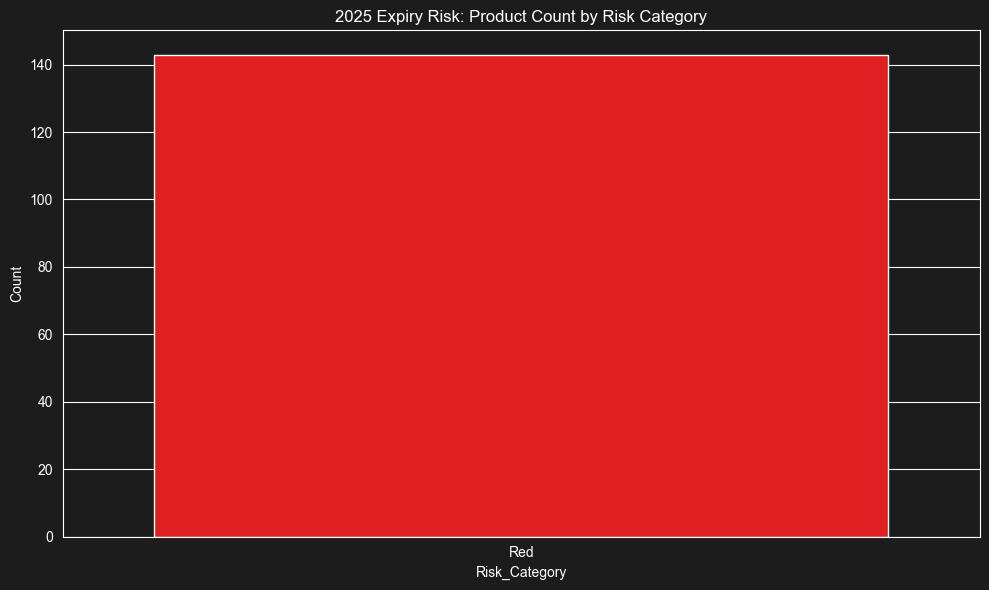

In [142]:
import plotly.express as px

# Assuming analyze_2025_expiry_risk() is already defined and used
expiry_risk_2025 = analyze_2025_expiry_risk(df_processed)

if expiry_risk_2025 is not None:
    # Display the number of products at risk of expiry in 2025
    print(f"Found {len(expiry_risk_2025)} products at risk of expiry in 2025")
    
    # Create an interactive bar chart for the top 10 products at risk of expiry in 2025
    fig = px.bar(expiry_risk_2025.head(10),
                 x='Product_Name',
                 y='Stock_On_Hand',
                 color='Expiry_Risk',
                 hover_data=['Product_Category', 'Days_To_Expiry', 'Unit_Price'],
                 title='Top 10 Products at Risk of Expiry in 2025',
                 labels={'Product_Name': 'Product', 'Stock_On_Hand': 'Stock Available'},
                 color_continuous_scale='reds')  # Use red color scale for urgency
    
    fig.update_layout(
        plot_bgcolor='black',
        paper_bgcolor='black',
        font=dict(color="white"),
        title_x=0.5
    )
    
    # Show the interactive plot
    fig.show()
    
    # Displaying the first 10 products at risk of expiry in 2025 in a tabular format
    print(expiry_risk_2025[['Product_Name', 'Product_Category', 'Stock_On_Hand', 'Days_To_Expiry', 'Expiry_Risk', 'Unit_Price']].head(10))
else:
    print("No expiry data available for 2025")


## 18. Executive Summary

In [143]:
# Generate executive summary
insights = generate_executive_summary(df_processed, overstocked, top_revenue, category_revenue, expiry_risk)

# Display summary
for i, insight in enumerate(insights, 1):
    print(f"{i}. {insight}")

Generating executive summary...
1. [PRIORITY] There are 258 overstocked products with a total value of $117920.53. Consider running promotions or reducing reorder quantities.
2. [PRIORITY] The Fruits & Vegetables category generates $91814.89 in revenue (26.7% of total). Consider expanding this product line.
3. [PRIORITY] 990 products worth $332069.71 will expire within 30 days. Immediate action required with promotions or discounts.
4. [PRIORITY] 452 products have low turnover rates (<1), tying up $205607.76 in inventory. Review pricing strategy and promotions.
5. [PRIORITY] 457 products are below reorder levels, putting $10013.84 in revenue at risk. Expedite restocking of top sellers.


## 19. Inventory Optimization Recommendations

In [144]:
# Calculate inventory efficiency metrics
inventory_value = (df_processed['Stock_On_Hand'] * df_processed['Unit_Price']).sum()
total_revenue = df_processed['Total_Revenue'].sum()
avg_inventory_turnover = df_processed['Inventory_Turnover_Ratio'].mean()

print(f"Total Inventory Value: ${inventory_value:.2f}")
print(f"Total Revenue: ${total_revenue:.2f}")
print(f"Average Inventory Turnover Ratio: {avg_inventory_turnover:.2f}")

# Calculate percentage of overstocked value
overstock_percentage = (overstock_value / inventory_value) * 100
print(f"Percentage of inventory value that is overstocked: {overstock_percentage:.2f}%")

Total Inventory Value: $332069.70
Total Revenue: $343724.54
Average Inventory Turnover Ratio: 1.48
Percentage of inventory value that is overstocked: 35.51%


In [145]:
# Display recommendations
print("Inventory Optimization Recommendations:")
print("1. Implement promotions for the top overstocked items to reduce inventory levels")
print("2. Adjust reorder levels for slow-moving products")
print("3. Consider discounting products with approaching expiry dates")
print("4. Focus on high-revenue product categories for inventory expansion")
print("5. Implement just-in-time inventory for fast-moving items")

Inventory Optimization Recommendations:
1. Implement promotions for the top overstocked items to reduce inventory levels
2. Adjust reorder levels for slow-moving products
3. Consider discounting products with approaching expiry dates
4. Focus on high-revenue product categories for inventory expansion
5. Implement just-in-time inventory for fast-moving items
